# Benchmark vs Challengers Comparison

This notebook compares benchmark models against challenger models (e.g., finetuned versions) across different forecast lead times.

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Import utils
from utils import (
    load_and_compute_metrics,
    create_color_palette,
    plot_improvement_stacked_bar,
    plot_skill_scatter,
    analyze_by_performance_tier,
    plot_tier_skill_analysis,
    compute_skill_correlation,
)

# Set style
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (14, 6)

## Configuration

In [2]:
# Path to benchmark model predictions
benchmark_path = "../results/evaluation/tajikistan_benchmark/model_name=*/seed=*/predictions.parquet"

# Dictionary of challenger paths with their display labels
challengers = {
    "Natural Finetuned": "../results/evaluation/natural_finetuned_tajikistan/model_name=*/seed=*/predictions.parquet",
    "Clusters Finetuned": "../results/evaluation/clusters_finetuned_tajikistan/model_name=*/seed=*/predictions.parquet"
}

# Lead times to analyze
lead_times_to_plot = [1, 5, 10]

# Metric to compute
metric = "nse"

## Load Data

In [3]:
# Load benchmark
print("Loading benchmark models...")
benchmark_metrics = load_and_compute_metrics(
    benchmark_path,
    "Benchmark",
    metric=metric,
    lead_times=lead_times_to_plot
)

# Load all challengers
challenger_metrics_list = []
for label, path in challengers.items():
    print(f"Loading {label}...")
    challenger_df = load_and_compute_metrics(
        path,
        label,
        metric=metric,
        lead_times=lead_times_to_plot
    )
    challenger_metrics_list.append(challenger_df)

# Combine all data
all_metrics = pl.concat([benchmark_metrics] + challenger_metrics_list)

# Extract model type
all_metrics = all_metrics.with_columns(
    pl.col("model_name").str.split("_").list.first().alias("model_type")
)

print(f"\nTotal metrics: {all_metrics.height} rows")
print(f"Model types: {all_metrics['model_type'].unique().sort().to_list()}")

Loading benchmark models...
Loading Natural Finetuned...
Loading Clusters Finetuned...

Total metrics: 468 rows
Model types: ['ealstm', 'tft', 'tide', 'tsmixer']


## Compute Comparisons

In [4]:
# Split benchmark and challengers
benchmark_only = all_metrics.filter(pl.col("model_version") == "Benchmark")
challengers_only = all_metrics.filter(pl.col("model_version") != "Benchmark")

# Join to compute deltas
comparison = challengers_only.join(
    benchmark_only.select(["group_identifier", "model_type", "lead_time", metric.upper()]),
    on=["group_identifier", "model_type", "lead_time"],
    how="inner",
    suffix="_benchmark"
)

# Compute delta and remaining skill captured
comparison = comparison.with_columns([
    (pl.col(metric.upper()) - pl.col(f"{metric.upper()}_benchmark")).alias(f"{metric}_delta"),
    # Remaining skill captured
    pl.when(pl.col(f"{metric.upper()}_benchmark") >= 0.9999)
    .then(None)
    .otherwise(
        (pl.col(metric.upper()) - pl.col(f"{metric.upper()}_benchmark")) / 
        (1.0 - pl.col(f"{metric.upper()}_benchmark"))
    )
    .alias("remaining_skill_captured")
])

print(f"\nComparison DataFrame: {comparison.height} rows")
comparison.head(5)


Comparison DataFrame: 312 rows


model_name,group_identifier,lead_time,NSE,model_version,model_type,NSE_benchmark,nse_delta,remaining_skill_captured
str,str,i64,f64,str,str,f64,f64,f64
"""ealstm_natural_tajikistan""","""tajik_16205""",1,0.990133,"""Natural Finetuned""","""ealstm""",0.986307,0.003826,0.279423
"""ealstm_natural_tajikistan""","""tajik_16205""",5,0.953545,"""Natural Finetuned""","""ealstm""",0.957266,-0.00372,-0.087062
"""ealstm_natural_tajikistan""","""tajik_16205""",10,0.920231,"""Natural Finetuned""","""ealstm""",0.922904,-0.002673,-0.034672
"""ealstm_natural_tajikistan""","""tajik_17077""",1,0.957443,"""Natural Finetuned""","""ealstm""",0.937143,0.020299,0.322949
"""ealstm_natural_tajikistan""","""tajik_17077""",5,0.863072,"""Natural Finetuned""","""ealstm""",0.859668,0.003404,0.02426


## Analysis 1: Stacked Bar - Improvement vs Degradation

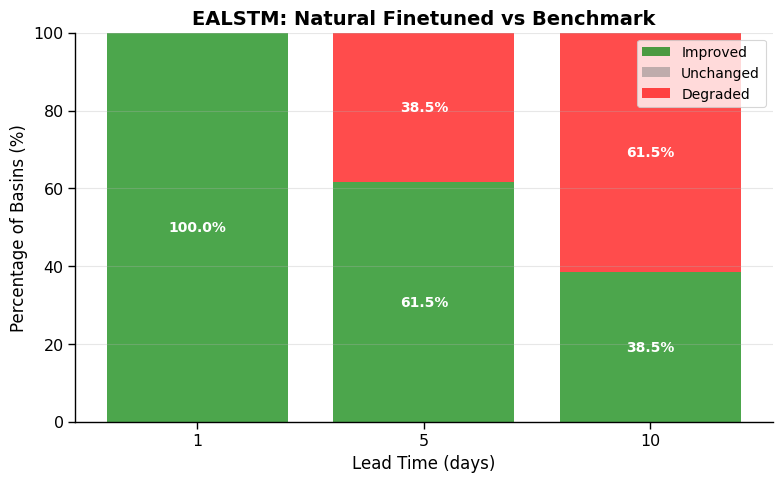


EALSTM - Natural Finetuned vs Benchmark:
Lead Time    Improved     Unchanged    Degraded    
------------------------------------------------
1.0          13.0 (100.0%)   0.0 (  0.0%)   0.0 (  0.0%)
5.0           8.0 ( 61.5%)   0.0 (  0.0%)   5.0 ( 38.5%)
10.0          5.0 ( 38.5%)   0.0 (  0.0%)   8.0 ( 61.5%)


In [5]:
# Example: EALSTM Natural Finetuned
plot_improvement_stacked_bar(
    comparison_df=comparison,
    model_type="ealstm",
    challenger_label="Natural Finetuned",
    metric=metric,
    lead_times=lead_times_to_plot
)

## Analysis 2: Remaining Skill Captured - Scatter Plot

/Users/nicolaslazaro/Desktop/work/publication-experiments/notebooks/utils/visualization.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


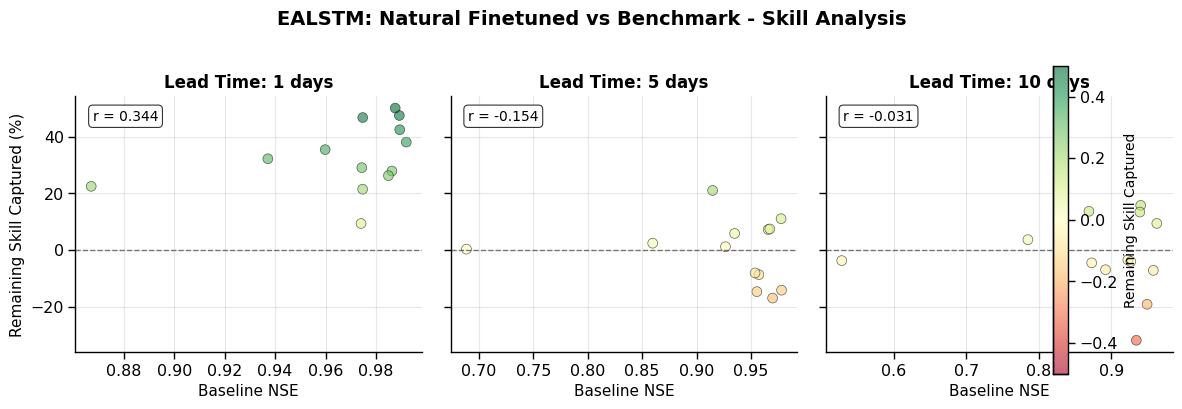


EALSTM - Natural Finetuned Skill Capture Analysis:
Interpretation:
  - Negative correlation → Finetuning helps low performers more
  - Positive correlation → Finetuning helps high performers more
  - Points above 0 → Captured remaining skill (improved)
  - Points below 0 → Lost skill (degraded)


In [6]:
# Scatter plot: Baseline NSE vs Remaining Skill Captured
plot_skill_scatter(
    comparison_df=comparison,
    model_type="ealstm",
    challenger_label="Natural Finetuned",
    metric=metric,
    lead_times=lead_times_to_plot
)

## Analysis 3: Performance Tier Analysis

In [7]:
# Stratified analysis by performance tier (per-horizon percentiles)
tier_stats = analyze_by_performance_tier(
    comparison_df=comparison,
    model_type="ealstm",
    challenger_label="Natural Finetuned",
    metric=metric,
    lead_times=lead_times_to_plot
)

print("\nPerformance Tier Statistics:")
print(tier_stats)


Performance Tier Statistics:
shape: (9, 10)
┌───────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬─────────┬───────────┐
│ lead_time ┆ performanc ┆ baseline_ ┆ mean_skil ┆ … ┆ n_improve ┆ n_degrade ┆ n_total ┆ pct_impro │
│ ---       ┆ e_tier     ┆ mean      ┆ l_capture ┆   ┆ d         ┆ d         ┆ ---     ┆ ved       │
│ i64       ┆ ---        ┆ ---       ┆ d         ┆   ┆ ---       ┆ ---       ┆ u32     ┆ ---       │
│           ┆ str        ┆ f64       ┆ ---       ┆   ┆ u32       ┆ u32       ┆         ┆ f64       │
│           ┆            ┆           ┆ f64       ┆   ┆           ┆           ┆         ┆           │
╞═══════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═════════╪═══════════╡
│ 1         ┆ High       ┆ 0.989576  ┆ 0.446343  ┆ … ┆ 4         ┆ 0         ┆ 4       ┆ 100.0     │
│ 1         ┆ Low        ┆ 0.934555  ┆ 0.249297  ┆ … ┆ 4         ┆ 0         ┆ 4       ┆ 100.0     │
│ 1         ┆ Medium     ┆ 0.979014  ┆ 0.30357

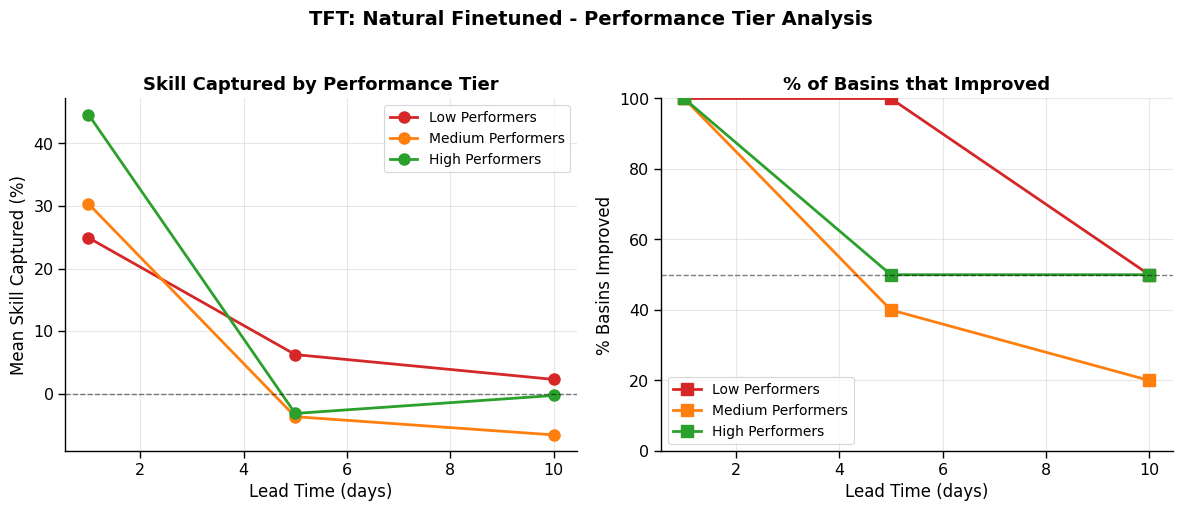


TFT - Natural Finetuned: Key Findings

Lead Time = 1 days:
     Low performers: Mean skill =  24.93%  |  100.0% improved  |  n=4
  Medium performers: Mean skill =  30.36%  |  100.0% improved  |  n=5
    High performers: Mean skill =  44.63%  |  100.0% improved  |  n=4

Lead Time = 5 days:
     Low performers: Mean skill =   6.25%  |  100.0% improved  |  n=4
  Medium performers: Mean skill =  -3.68%  |   40.0% improved  |  n=5
    High performers: Mean skill =  -3.17%  |   50.0% improved  |  n=4

Lead Time = 10 days:
     Low performers: Mean skill =   2.28%  |   50.0% improved  |  n=4
  Medium performers: Mean skill =  -6.60%  |   20.0% improved  |  n=5
    High performers: Mean skill =  -0.29%  |   50.0% improved  |  n=4


In [8]:
# Visualize tier analysis
plot_tier_skill_analysis(
    tier_stats=tier_stats,
    model_type="tft",
    challenger_label="Natural Finetuned"
)

## Analysis 4: Correlation Statistics

In [9]:
# Compute correlation between baseline NSE and remaining skill captured
correlations = compute_skill_correlation(
    comparison_df=comparison,
    model_type="ealstm",
    challenger_label="Natural Finetuned",
    metric=metric,
    lead_times=lead_times_to_plot
)

print("\nCorrelation Analysis:")
print("=" * 80)
print(correlations)
print("\nInterpretation:")
print("  - Negative correlation → Finetuning helps low performers more")
print("  - Positive correlation → Finetuning helps high performers more")
print("  - Near-zero → Effect independent of baseline performance")
print("=" * 80)


Correlation Analysis:
shape: (3, 4)
┌───────────┬───────────┬────────────┬──────────┐
│ lead_time ┆ pearson_r ┆ spearman_r ┆ n_basins │
│ ---       ┆ ---       ┆ ---        ┆ ---      │
│ i64       ┆ f64       ┆ f64        ┆ i64      │
╞═══════════╪═══════════╪════════════╪══════════╡
│ 1         ┆ 0.344338  ┆ 0.565934   ┆ 13       │
│ 5         ┆ -0.154248 ┆ -0.181319  ┆ 13       │
│ 10        ┆ -0.031002 ┆ -0.115385  ┆ 13       │
└───────────┴───────────┴────────────┴──────────┘

Interpretation:
  - Negative correlation → Finetuning helps low performers more
  - Positive correlation → Finetuning helps high performers more
  - Near-zero → Effect independent of baseline performance
